In [22]:
%load_ext autoreload

%autoreload 2

from torch import nn
import numpy as np
from utils import generate_random_numbers, plot_distribution
import torch

from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def custom_pdf(x):
    mean1, std1 = 2, 0.5
    mean2, std2 = 5, 0.5
    mean3, std3 = 8, 0.5

    gauss1 = np.exp(-0.5 * ((x - mean1) / std1) ** 2) / (std1 * np.sqrt(2 * np.pi))
    gauss2 = np.exp(-0.5 * ((x - mean2) / std2) ** 2) / (std2 * np.sqrt(2 * np.pi))
    gauss3 = np.exp(-0.5 * ((x - mean3) / std3) ** 2) / (std3 * np.sqrt(2 * np.pi))

    # sinusoidal_modulation = 0.5 * (1 + np.sin(2 * np.pi * x / 10))

    # return (gauss1 + gauss2 + gauss3) * sinusoidal_modulation
    return (gauss1 + gauss2 + gauss3) 

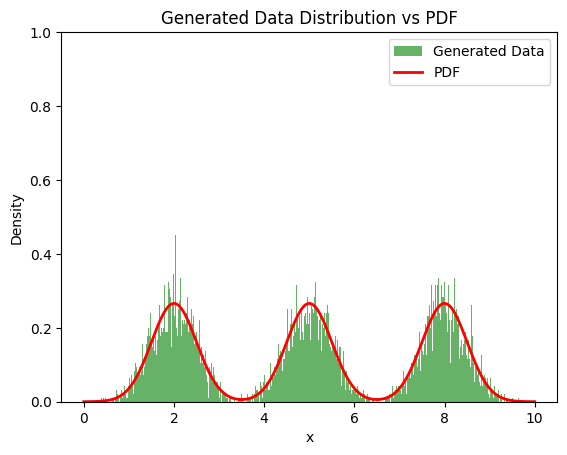

In [24]:
x_range = (0, 10)
num_samples = 10000
samples = generate_random_numbers(custom_pdf, x_range, num_samples)
plot_distribution(samples, custom_pdf, x_range)

In [ ]:
z_dim = 3
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True  # Whether the generator should be tested
gen_loss = False
error = False
n_epochs = 100
display_step = 10
batch_size = 128
lr = 0.00001
n_samples = batch_size

torch.manual_seed(0)  # Set for testing purposes, please do not change!
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("Using CPU device.")



In [ ]:
class NumbersDataset(Dataset):
    def __init__(self, numbers):
        self.numbers = numbers

    def __len__(self):
        return len(self.numbers)

    def __getitem__(self, idx):
        number = self.numbers[idx]
        return torch.tensor(number, dtype=torch.float32)

# Example usage


In [ ]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True)
    )
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            # nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
    def get_gen(self):
        return self.gen
class Discriminator(nn.Module):

    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)
    
    def get_disc(self):
        return self.disc

In [ ]:
gen = Generator(z_dim, im_dim=1, hidden_dim=100).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_dim=1).to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()
dataset = NumbersDataset(samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

for epoch in range(n_epochs):
    for real in tqdm(dataloader):
        # image : 128, 1, 28, 28
        cur_batch_size = len(real)
        real_images = real.view(cur_batch_size, -1).to(device)
        # Train the discriminator 
        disc_opt.zero_grad()
        
        # Generate fake images and calculate fake loss of discriminator
        noise = torch.randn(n_samples, z_dim, device=device)
        fake_images = gen(noise)
        disc_fake_pred = disc(fake_images)

        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        # Use real images to calculate real loss of discriminator
        disc_real_pred = disc(real_images)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        disc_loss = disc_real_loss + disc_fake_loss
        disc_loss.backward()
        disc_opt.step()


        # Train the generator
        gen_opt.zero_grad()
        noise = torch.randn(n_samples, z_dim, device=device)
        fake_images = gen(noise)
        desc_fake_pred = disc(fake_images)

        gen_loss = criterion(desc_fake_pred, torch.ones_like(desc_fake_pred))

        gen_loss.backward()
        gen_opt.step()
 

        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = torch.randn(n_samples, z_dim, device=device)
            fake = gen(fake_noise)

            plot_distribution(fake.squeeze().detach().numpy(), custom_pdf, x_range)
            # show_tensor_images(fake)
            # show_tensor_images(real_images)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


In [ ]:
fake_noise = torch.randn(10000, z_dim, device=device)
gen.eval()
fake = gen(fake_noise)

plot_distribution(fake.squeeze().detach().numpy(), custom_pdf, x_range)

In [ ]:
min(fake.squeeze().detach().numpy())